#  Prédiction des plafonds de caisse dans les agences bancaires

Ce projet a pour objectif de prédire les limites de caisse nécessaires dans chaque agence bancaire 
en s'appuyant sur des données historiques de type, de location, de volume et de comportement de transactions monétaires dans 250 agences de banques sur une période de 370 jours.

Dans notre dataset, le 'branch limit' est fixe pour chaque agence, notre but et de pouvoir calculer le bon plafond à attribuer à chaque agence dynamiquement chaque jour, notre modèle devra alors prédire le caractéristique "closing_balance" correctement, sur lequel la banque pourra se baser par la suite pour fixer cette limite.



## 1. Chargement et familiarisation avec les données

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [69]:
data = pd.read_excel("Cash_Management_Branch_Limit_Forecasting.xlsx")

In [70]:
data.head()

,Branch_Code,Gov,Location Nature,ATMs,Inflow,Outflow,Net_Movement,Upcoming_Holiday,Imports_Count,Exports_Count,...,Quarter_ID,Month_Name,Inflow_Transactions_Count,Outflow_Transactions_Count,Date,Day_Name,Opening_Balance,Closing_Balance,Branch_Size,Branch_Type
0,1,Tanta,university,9.0,1.351055e+07,2.032398e+07,-6.813431e+06,0,0,0,...,1,January,195,105,2023-01-01,Sunday,87520650.23,8.070722e+07,Medium,Traditional
1,2,Fayoum,public,25.0,9.509461e+06,5.128011e+06,4.381450e+06,0,0,0,...,1,January,145,110,2023-01-01,Sunday,87520650.23,9.190210e+07,Medium,Mix
2,3,Mansoura,resort,5.0,2.893720e+07,3.258410e+07,-3.646906e+06,0,0,0,...,1,January,75,215,2023-01-01,Sunday,87520650.23,8.387374e+07,Medium,Traditional
3,4,Tanta,governmental institute,0.0,6.874908e+06,2.728970e+07,-2.041480e+07,0,0,0,...,1,January,215,150,2023-01-01,Sunday,87520650.23,6.710585e+07,Medium,Traditional
4,5,Hurghada,border location,1.0,1.413602e+07,2.699331e+07,-1.285730e+07,0,0,0,...,1,January,40,90,2023-01-01,Sunday,87520650.23,7.466335e+07,Medium,Traditional


In [71]:
print(f"Nombre de lignes : {data.shape[0]}")
print(f"Nombre de colonnes : {data.shape[1]}")

Nombre de lignes : 92500
Nombre de colonnes : 25


In [72]:
#le nom de toutes nos features
data.columns

Index(['Branch_Code', 'Gov', 'Location Nature', 'ATMs', 'Inflow', 'Outflow',
       'Net_Movement', 'Upcoming_Holiday', 'Imports_Count', 'Exports_Count',
       'Imports_Amount', 'Exports_Amount', 'Branch_Limit', 'asdfghjkl',
       'Feature_2', 'Quarter_ID', 'Month_Name', 'Inflow_Transactions_Count',
       'Outflow_Transactions_Count', 'Date', 'Day_Name', 'Opening_Balance',
       'Closing_Balance', 'Branch_Size', 'Branch_Type'],
      dtype='object')

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92500 entries, 0 to 92499
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Branch_Code                 92500 non-null  int64         
 1   Gov                         92500 non-null  object        
 2   Location Nature             92500 non-null  object        
 3   ATMs                        88800 non-null  float64       
 4   Inflow                      92500 non-null  float64       
 5   Outflow                     92500 non-null  float64       
 6   Net_Movement                92500 non-null  float64       
 7   Upcoming_Holiday            92500 non-null  int64         
 8   Imports_Count               92500 non-null  int64         
 9   Exports_Count               92500 non-null  int64         
 10  Imports_Amount              92500 non-null  float64       
 11  Exports_Amount              92500 non-null  float64   

In [74]:
#recherche de lignes dupliqués
duplicates = data.duplicated()

print(f'Nombre de lignes de dupliqués: {duplicates.sum()}')

Nombre de lignes de dupliqués: 0


In [75]:
# Aperçu des types
data.dtypes.value_counts()

float64           10
int64              8
object             6
datetime64[ns]     1
Name: count, dtype: int64

In [76]:
# Vérifier les valeurs manquantes
data.isnull().sum().sort_values(ascending=False)

ATMs                          3700
Branch_Code                      0
Gov                              0
Location Nature                  0
Inflow                           0
Outflow                          0
Net_Movement                     0
Upcoming_Holiday                 0
Imports_Count                    0
Exports_Count                    0
Imports_Amount                   0
Exports_Amount                   0
Branch_Limit                     0
asdfghjkl                        0
Feature_2                        0
Quarter_ID                       0
Month_Name                       0
Inflow_Transactions_Count        0
Outflow_Transactions_Count       0
Date                             0
Day_Name                         0
Opening_Balance                  0
Closing_Balance                  0
Branch_Size                      0
Branch_Type                      0
dtype: int64

In [77]:
# Sélection des colonnes non numériques
non_numeric_cols = data.select_dtypes(exclude=['number'])

print("Colonnes non numériques :", list(non_numeric_cols.columns))


Colonnes non numériques : ['Gov', 'Location Nature', 'Month_Name', 'Date', 'Day_Name', 'Branch_Size', 'Branch_Type']


On observe que parmi nos 25 features, on en qu'une seule qui contient de nan (dans 3700 parmi nos 92500 lignes), il faudra traiter cela, ainsi que les 7 features de type non-numérique.

## 2.  Nettoyage et préparation des données

## A. filtrage logique
Depuis notre compréhension du sujet, on comprend que les agences de type "digitale" ne sont pas concernées dans notre modèle puisqu'il n'y a pas de monnaie physique là-dedans, et donc pas de limite à prédire.
On analyse donc spécifiquement ce type qui pourraient fausser l’analyse de la variable cible `Branch_Limit`.

In [78]:
data[data.Branch_Type == "Digital"]["Branch_Limit"]

7        0
12       0
16       0
24       0
25       0
        ..
92398    0
92430    0
92451    0
92455    0
92468    0
Name: Branch_Limit, Length: 9620, dtype: int64

Le branch_limit est toujours à 0, donc on voudrait exclure les lignes qui représentent ce type de notre dataframe ( et ne garder que les 2 autres types: traditionnal et mix, qui ont de réelles limites de cash)

In [79]:
data = data[data.Branch_Type.isin(["Traditional","Mix"])]

In [80]:
data.Branch_Type.value_counts()

Branch_Type
Traditional    59940
Mix            22940
Name: count, dtype: int64

In [81]:
data.shape

(82880, 25)

On a ainsi réduit notre nombre de lignes à 82880 (dont presque 3/4 sont traditionnels, et 1/4 est mix entre digital et traditionnel)

## B. Transformation de variables non-numériques
Pour les 7 features de type non-numériques , on ne voulait pas perdre leur influence sur la prédiction puisque les modèles de machine learning ne traitent pas directement les chaînes de caractères.  
Donc on voudrait les transformer en colonnes qui peuvent etre apprises dans notre modèle.
on a trouvé deux solutions pour faire cela: 
- le hot-one encoding( qui consiste à créer une nouvelle colonne pour chaque valeur possible et avoir les lignes sous forme de bool en 1 pour la valeur correspondante, et 0 pour le reste).
- le mapping (si on a nombre limité de valeurs possibles, attribuer à chacune d'entre elle un entier représentatif)

In [82]:
data = pd.get_dummies(data, columns=['Gov','Day_Name','Month_Name','Location Nature','Branch_Type'], prefix=['Gov','Day_Name','Month_Name','Location_Nature','Branch_Type'])

In [83]:
#visulaiser les nouvelles colonnes qu'on a crée
data.columns

Index(['Branch_Code', 'ATMs', 'Inflow', 'Outflow', 'Net_Movement',
       'Upcoming_Holiday', 'Imports_Count', 'Exports_Count', 'Imports_Amount',
       'Exports_Amount', 'Branch_Limit', 'asdfghjkl', 'Feature_2',
       'Quarter_ID', 'Inflow_Transactions_Count', 'Outflow_Transactions_Count',
       'Date', 'Opening_Balance', 'Closing_Balance', 'Branch_Size',
       'Gov_Alexandria', 'Gov_Aswan', 'Gov_Cairo', 'Gov_Fayoum', 'Gov_Giza',
       'Gov_Hurghada', 'Gov_Ismailia', 'Gov_Luxor', 'Gov_Mansoura',
       'Gov_Port Said', 'Gov_Suez', 'Gov_Tanta', 'Day_Name_Monday',
       'Day_Name_Sunday', 'Day_Name_Thursday', 'Day_Name_Tuesday',
       'Day_Name_Wednesday', 'Month_Name_April', 'Month_Name_August',
       'Month_Name_December', 'Month_Name_February', 'Month_Name_January',
       'Month_Name_July', 'Month_Name_June', 'Month_Name_March',
       'Month_Name_May', 'Month_Name_November', 'Month_Name_October',
       'Month_Name_September', 'Location_Nature_border location',
       'Locat

pour le branch size, c'était plus logique de transformer les valeurs 'small', 'medium', et 'large' en les entiers 1,2,3 respectivement

In [84]:
branch_size_mapping = {
    'Small': 1,
    'Medium': 2,
    'Large': 3
}

In [85]:
data['Branch_Size'] = data['Branch_Size'].map(branch_size_mapping)

In [ ]:
#vérifier que toutes les features sont bien typées
data.dtypes

Branch_Code                                        int64
ATMs                                             float64
Inflow                                           float64
Outflow                                          float64
Net_Movement                                     float64
Upcoming_Holiday                                   int64
Imports_Count                                      int64
Exports_Count                                      int64
Imports_Amount                                   float64
Exports_Amount                                   float64
Branch_Limit                                       int64
asdfghjkl                                        float64
Feature_2                                        float64
Quarter_ID                                         int64
Inflow_Transactions_Count                          int64
Outflow_Transactions_Count                         int64
Date                                      datetime64[ns]
Opening_Balance                

## C. Gestion des valeurs manquantes
On voudrait initialement simplement supprimer les lignes avec des valeurs nan, mais puisque ce n'est que dans la colonne 'ATMS' et que ce nombre reste fixe normalement pour chaque agence et qu'il est toujours bien présent et identique à d'autres dates, on a voulu garder le plus d'imformations possibles en remplissant correctement les champs manquants.

In [ ]:
#fonction qui remplit les nan dans une colonne donnée en utilisant le mode par agence
def fill_missing_with_mode(group, column):
    mode_value = group[column].mode()
    if not mode_value.empty:
        group[column].fillna(mode_value.iloc[0], inplace=True)
    return group

In [ ]:
data = data.groupby('Branch_Code').apply(lambda x: fill_missing_with_mode(x, 'ATMs'))
data= data.reset_index(drop=True)

C:\Users\Malak\AppData\Local\Temp\ipykernel_9668\2835612411.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  group[column].fillna(mode_value.iloc[0], inplace=True)
C:\Users\Malak\AppData\Local\Temp\ipykernel_9668\2245829447.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

In [ ]:
#vérifier qu'on n'a plus de valeurs manquantes
data.isnull().sum()

Branch_Code                               0
ATMs                                      0
Inflow                                    0
Outflow                                   0
Net_Movement                              0
Upcoming_Holiday                          0
Imports_Count                             0
Exports_Count                             0
Imports_Amount                            0
Exports_Amount                            0
Branch_Limit                              0
asdfghjkl                                 0
Feature_2                                 0
Quarter_ID                                0
Inflow_Transactions_Count                 0
Outflow_Transactions_Count                0
Date                                      0
Opening_Balance                           0
Closing_Balance                           0
Branch_Size                               0
Gov_Alexandria                            0
Gov_Aswan                                 0
Gov_Cairo                       

## 3. Exploration des données
On observe qu'est ce qui pourrait le plus influencer la fetaure qu'on veut etre capable de prédire: 'Closing_Balance'.

In [ ]:
#fixer les dates et le code de l'agence comme index pour mieux visuliser
indexed_data = data.set_index(['Date', 'Branch_Code'])
indexed_data

,,ATMs,Inflow,Outflow,Net_Movement,Upcoming_Holiday,Imports_Count,Exports_Count,Imports_Amount,Exports_Amount,Branch_Limit,...,Location_Nature_border location,Location_Nature_club,Location_Nature_compound,Location_Nature_governmental institute,Location_Nature_mall,Location_Nature_public,Location_Nature_resort,Location_Nature_university,Branch_Type_Mix,Branch_Type_Traditional
Date,Branch_Code,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1,9.0,1.351055e+07,2.032398e+07,-6.813431e+06,0,0,0,0.0,0.0,41500000,...,False,False,False,False,False,False,False,True,False,True
2023-01-02,1,9.0,9.201269e+06,1.690044e+07,-7.699172e+06,0,0,0,0.0,0.0,41500000,...,False,False,False,False,False,False,False,True,False,True
2023-01-03,1,9.0,1.974940e+07,1.339009e+07,6.359307e+06,0,0,0,0.0,0.0,41500000,...,False,False,False,False,False,False,False,True,False,True
2023-01-04,1,9.0,7.117253e+06,2.828122e+06,4.289132e+06,0,0,0,0.0,0.0,41500000,...,False,False,False,False,False,False,False,True,False,True
2023-01-05,1,9.0,1.010226e+07,7.543427e+06,2.558834e+06,1,0,0,0.0,0.0,41500000,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19,250,25.0,4.234247e+06,6.447136e+06,-2.212889e+06,1,0,0,0.0,0.0,44000000,...,False,True,False,False,False,False,False,False,False,True
2024-06-20,250,25.0,4.642059e+07,3.233334e+07,1.408726e+07,1,0,0,0.0,0.0,44000000,...,False,True,False,False,False,False,False,False,False,True
2024-06-24,250,25.0,1.576954e+07,7.844991e+06,7.924546e+06,1,0,0,0.0,0.0,44000000,...,False,True,False,False,False,False,False,False,False,True


In [ ]:
data.describe()

,Branch_Code,ATMs,Inflow,Outflow,Net_Movement,Upcoming_Holiday,Imports_Count,Exports_Count,Imports_Amount,Exports_Amount,Branch_Limit,asdfghjkl,Feature_2,Quarter_ID,Inflow_Transactions_Count,Outflow_Transactions_Count,Date,Opening_Balance,Closing_Balance,Branch_Size
count,82880.000000,82880.000000,8.288000e+04,8.288000e+04,8.288000e+04,82880.000000,82880.000000,82880.000000,8.288000e+04,8.288000e+04,8.288000e+04,8.288000e+04,8.288000e+04,82880.000000,82880.000000,82880.000000,82880,8.288000e+04,8.288000e+04,82880.000000
mean,128.718750,13.915179,1.756716e+07,1.752247e+07,4.468520e+04,0.208108,0.099517,0.151086,4.973007e+05,7.636478e+05,3.569307e+07,5.062242e+07,5.057330e+07,2.170270,124.983953,124.924771,2023-09-25 23:24:58.378378240,1.855614e+08,1.860690e+08,1.870536
min,1.000000,0.000000,1.074500e+05,1.094645e+05,-7.848097e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.002675e+06,1.000167e+06,1.000000,5.000000,5.000000,2023-01-01 00:00:00,7.150723e+03,7.150723e+03,1.000000
25%,64.750000,6.000000,7.948836e+06,7.893309e+06,-9.137585e+06,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.000000e+07,2.586084e+07,2.584112e+07,1.000000,65.000000,65.000000,2023-05-11 00:00:00,8.926846e+07,8.981118e+07,1.000000
50%,130.500000,14.000000,1.570549e+07,1.565204e+07,-6.617635e+03,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,3.750000e+07,5.047698e+07,5.062631e+07,2.000000,125.000000,125.000000,2023-09-25 12:00:00,1.509016e+08,1.515233e+08,2.000000
75%,191.250000,21.000000,2.418051e+07,2.407565e+07,9.334982e+06,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,5.250000e+07,7.544321e+07,7.525801e+07,3.000000,185.000000,185.000000,2024-02-08 00:00:00,2.535777e+08,2.542758e+08,2.000000
max,250.000000,27.000000,8.011193e+07,7.991512e+07,7.535532e+07,1.000000,2.000000,3.000000,1.999127e+07,2.999789e+07,7.000000e+07,1.000000e+08,9.999990e+07,4.000000,245.000000,245.000000,2024-06-27 00:00:00,9.224270e+08,9.224270e+08,3.000000
std,72.557167,8.439803,1.234727e+07,1.237098e+07,1.504752e+07,0.405957,0.434895,0.656076,2.521115e+06,3.837090e+06,2.015418e+07,2.860980e+07,2.857969e+07,1.063241,70.623782,70.672877,NaN,1.294345e+08,1.297710e+08,0.658891


In [ ]:
# Calcul des corrélations
correlation_matrix = data.corr(numeric_only=True)

In [ ]:
# Sélection des 10 variables les plus corrélées à Closing_Balance
top_corr = correlation_matrix['Closing_Balance'].abs().sort_values(ascending=False).head(11).index 

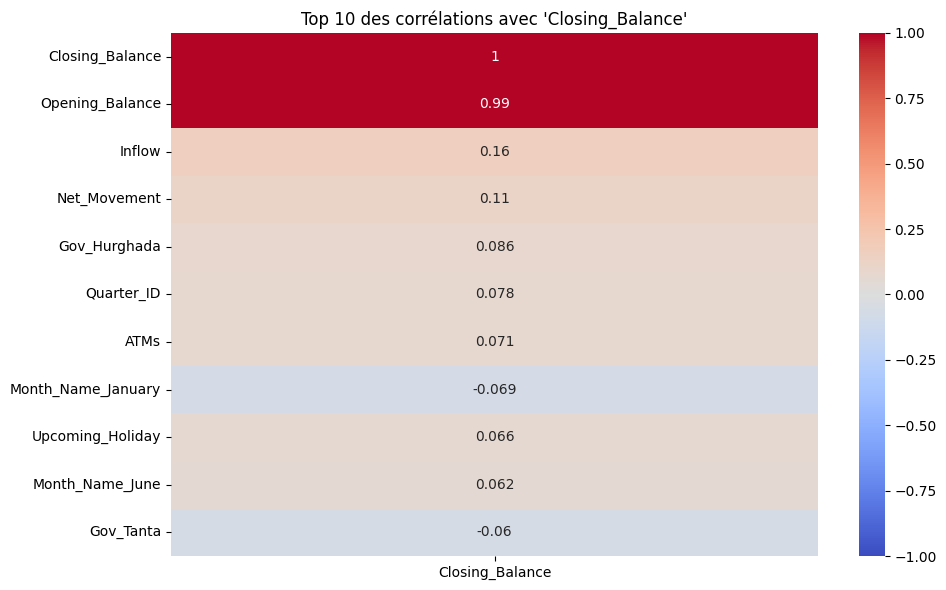

In [ ]:
# Heatmap sur ces variables seulement
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix.loc[top_corr, ['Closing_Balance']],
    annot=True, cmap='coolwarm', vmin=-1, vmax=1
)
plt.title("Top 10 des corrélations avec 'Closing_Balance'")
plt.tight_layout()
plt.show()

C:\Users\Malak\AppData\Local\Temp\ipykernel_9668\1167544344.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.set_index('Date')['Closing_Balance'].resample('M').mean().plot(figsize=(10,4))


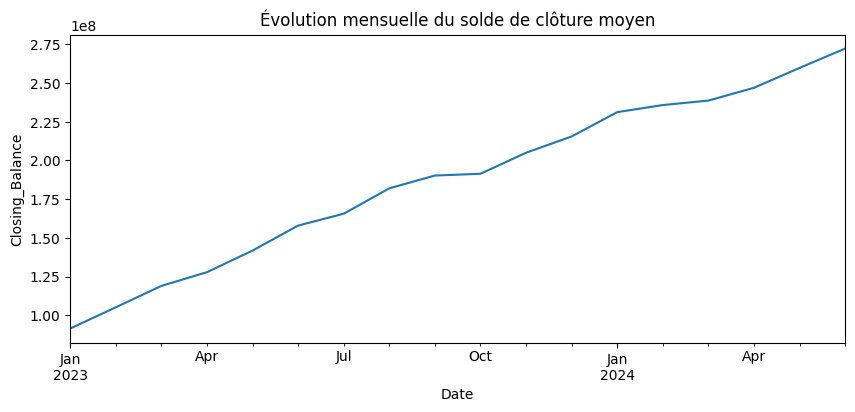

In [ ]:
# évolution temporelle
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date')['Closing_Balance'].resample('M').mean().plot(figsize=(10,4))
plt.title("Évolution mensuelle du solde de clôture moyen")
plt.ylabel("Closing_Balance")
plt.show()

## 4. Standarisation et ingènierie des features avec PCA
Notamment après l'encodage hot-one, on aimerait réduire la taille de nos fetaures, donc on va appliquer le PCA pour réduire la dimensionnalité des données tout en gardant l'essentiel de l'information.

Pour ne pas influenecer la performance de notre modèle, on commencera par diviser le dataset en train et test et appliquera le PCA uniquement sur les données du set train.

In [ ]:
# 1. Séparation variables explicatives / cible
# On retire la colonne date qui n'est pas numérique
X = data.drop(columns=["Closing_Balance", "Date"])
y = data["Closing_Balance"]

In [111]:
# 2. Split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
# 3. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [114]:
# 4. PCA : on peut d’abord tester la variance expliquée cumulée
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Choix du nombre de composantes PCA:

Nous visualisons ici la **variance expliquée cumulée** par les composantes principales.  
Cela nous aide à déterminer le **nombre optimal de composantes** à conserver (par exemple, celles qui expliquent 90 à 95 % de la variance totale).



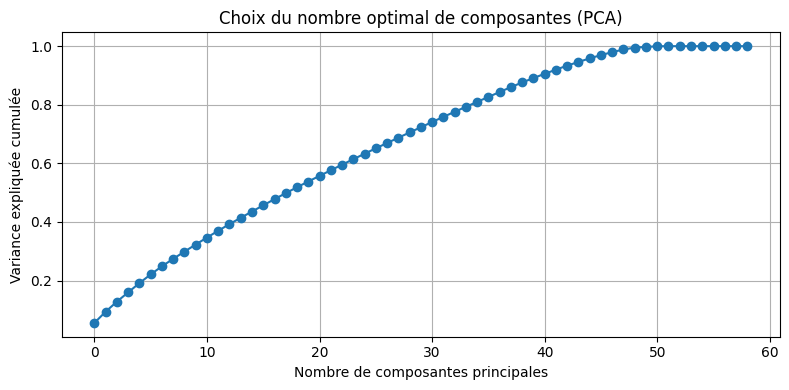

In [115]:
# Affichage de la variance expliquée cumulée
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Choix du nombre optimal de composantes (PCA)')
plt.grid(True)
plt.tight_layout()
plt.show()

On atteint 90% de vraiance depuis 40 composantes, mais pour tester le meilleur nombre et voir si on pourrait raffiner encore, on va utiliser le gridserachCV

In [145]:
# Pipeline complet
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsRegressor())
])

In [146]:
# Paramètres à tester
param_grid = {
    'pca__n_components': [40, 45, 50],
    'knn__n_neighbors': [3, 5, 7]  
}

In [147]:
# GridSearch
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'pca__n_components': [40, 45, 50]},
             scoring='r2', verbose=1)

In [148]:
print("Meilleur nombre de composantes PCA :", grid.best_params_['pca__n_components'])
print("Meilleur nombre de voisins k :", grid.best_params_['knn__n_neighbors'])
print("Meilleur score R² (validation croisée) :", round(grid.best_score_, 4))

Meilleur nombre de composantes PCA : 50
Meilleur nombre de voisins k : 7
Meilleur score R² (validation croisée) : 0.7448


Le `GridSearchCV` a sélectionné 50 composantes principales comme étant les plus efficaces pour la modélisation.

Cela peut sembler beaucoup, mais cela reflète une variabilité répartie sur plusieurs dimensions, que le modèle a besoin de conserver pour bien prédire ( on n'a pas trop de fetaures redondantes,ils apportent, pour la très grande majorité, chacun une information différente)

Donc meme si le PCA ne nous a pas servi à réduire drastiquement, il aide quand meme à organiser les données de manière plus informative.

## 5. Modélisation et évaluation des performances

On va maintenant essayer différents modèles de regression pour prédire le 'Closing_Balance':

- Régression linéaire
- Arbre de décision
- RandomForest
- K plus proches voisins (KNN)
- AdaBoost
- Gradient Boosting

In [ ]:
def train_models(x_train, y_train, x_test, y_test):
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'LinearRegression': LinearRegression(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'KNeighbors': KNeighborsRegressor(),
        'AdaBoost': AdaBoostRegressor(random_state=42),
    }

    results = []

    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        print(f"🔹 {name}")
        print(f"  R²    : {r2:.4f}")
        print(f"  RMSE  : {rmse:.2f}")
        print(f"  MAE   : {mae:.2f}")
        print()

        results.append({
            'Modèle': name,
            'R²': r2,
            'RMSE': rmse,
            'MAE': mae
        })

    return results

On va essayer ces modèles sur le jeu de données une fois avec, et une fois sans pca.

Pour chaque modèle, nous mesurons :
- **R²** : coeffecient de détermination
            = pourcentage de l'adéquation des prédictions aux données réelles    
- **RMSE** : erreur quadratique moyenne
            = l'écart moyen entre valeurs prédites et réelles
- **MAE** : erreur absolue moyenne
            = différence moyenne entre valeurs prédites et réelles

In [153]:
results = train_models(X_train_pca, y_train, X_test_pca, y_test)

🔹 RandomForest
  R²    : 0.9301
  RMSE  : 34276602.06
  MAE   : 25791015.95

🔹 GradientBoosting
  R²    : 0.8832
  RMSE  : 44318472.98
  MAE   : 34934583.60

🔹 LinearRegression
  R²    : 0.9971
  RMSE  : 6974104.97
  MAE   : 1318475.19

🔹 DecisionTree
  R²    : 0.7801
  RMSE  : 60821090.16
  MAE   : 42678255.87

🔹 KNeighbors
  R²    : 0.7594
  RMSE  : 63620642.91
  MAE   : 48002644.31

🔹 AdaBoost
  R²    : 0.6766
  RMSE  : 73749838.14
  MAE   : 61890436.67



In [154]:
results_base = train_models(X_train_scaled, y_train, X_test_scaled, y_test)

🔹 RandomForest
  R²    : 0.9997
  RMSE  : 2137345.46
  MAE   : 432007.09

🔹 GradientBoosting
  R²    : 0.9991
  RMSE  : 3828024.00
  MAE   : 1859622.31

🔹 LinearRegression
  R²    : 0.9971
  RMSE  : 6980650.06
  MAE   : 1380103.77

🔹 DecisionTree
  R²    : 0.9993
  RMSE  : 3416650.39
  MAE   : 1053899.21

🔹 KNeighbors
  R²    : 0.7594
  RMSE  : 63620642.91
  MAE   : 48002644.31

🔹 AdaBoost
  R²    : 0.9835
  RMSE  : 16635271.01
  MAE   : 13184461.11



In [155]:
df_pca = pd.DataFrame(results)
df_base = pd.DataFrame(results_base)

df_pca['Version'] = 'PCA'
df_base['Version'] = 'Données brutes'

df_all = pd.concat([df_pca, df_base])

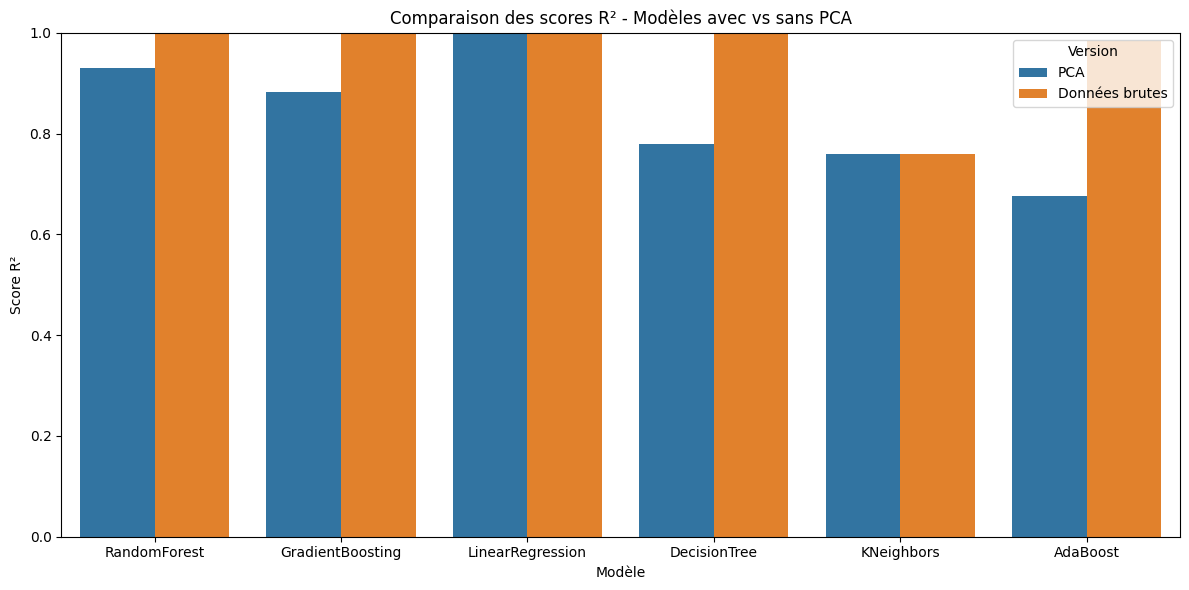

In [156]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_all, x='Modèle', y='R²', hue='Version')
plt.title("Comparaison des scores R² - Modèles avec vs sans PCA")
plt.ylim(0, 1)
plt.ylabel("Score R²")
plt.legend(title='Version')
plt.tight_layout()
plt.show()

Nous avons comparé les performances de six algorithmes de régression sur deux versions des données :
- Les données d’origine, après standardisation
- Les données réduites via PCA (50 composantes principales)

 Les résultats montrent que, dans ce cas :
- Les modèles entraînés sans PCA obtiennent de meilleurs scores.
- Cela suggère que la réduction de dimension par PCA n’est pas bénéfique ici, probablement parce que les variables originales sont déjà bien structurées et informatives
- Certains modèles comme la **Régression Linéaire**, **Gradient Boosting** et **Random Forest** **DecisionTree** **AdaBoost** atteignent un score de R² très proche de 1.00 sans PCA, ce qui confirme leur capacité à bien généraliser

Pour les données sans PCA, RandomForest se trouve en premier avec une minuscule différence de R2 par rapprt à sa compétition, alors que pour les données avec PCA, Linear Regression prend le devant.

Et il est importer de noter que le modèle **LinearRegression** donne les mêmes exactes scores avant et après PCA car le PCA ne modifie pas les relations linéaires dans les données. Il réorganise les axes mais ne détruit pas l'information utile pour un modèle linéaire. C’est pourquoi les performances restent identiques tant que toutes les composantes sont conservées.

Nous retenons donc les données brutes comme meilleur choix pour ce jeu, tout en gardant le PCA comme outil d’analyse complémentaire.


## 6. Conclusion



Ce projet visait à prédire le solde de clôture (`Closing_Balance`) des agences bancaires à partir de leurs caractéristiques.

Nous avons suivi les étapes classiques de l’apprentissage automatique :
- **Nettoyage et exploration des données**
- **Traitement des différents cas inconsistents**
- **Standardisation et réduction de dimension (PCA)**
- **Comparaison de plusieurs modèles de régression**

Ce que nous avons appris :
- Le **PCA est un bon outil exploratoire**, mais son usage doit être validé par des tests : ici, les données d’origine étaient plus performantes.
- Certains modèles comme **Random Forest** ou **Gradient Boosting** ont montré une très bonne capacité de prédiction.
- L'importance de **séparer correctement les données de test**, de **standardiser avant PCA**, et de **tester plusieurs approches** pour justifier nos choix.

Ce projet nous a permis de consolider notre compréhension des pipelines ML et de l’évaluation rigoureuse des modèles.
